In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

# 获取初级对话框

1. `bubble_contours`: 轮廓信息
2. `rects`: 最小外接矩形坐标

In [2]:
# 读取图片
image_path = './dataset/panels/color/18/1.jpg'
img = cv2.imread(image_path)

# 转换为灰度图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_h,img_w = gray.shape

# 应用阈值处理得到二值图像
# 检测对象为白色，背景为黑色
_, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# 去除黑色背景里的白色噪点
kernel = np.ones((5,5), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# 保留白色前景的轮廓
kernel = np.ones((5,5), np.uint8)
gradient = cv2.morphologyEx(opening, cv2.MORPH_GRADIENT, kernel)

binary = gradient

# 查找所有轮廓，并建立等级关系
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy.reshape(-1,4)

In [3]:
# 查找最外层轮廓的子轮廓，设置为0
# 查找最外层轮廓，设置为-1
parent_contour_index = -1
 
top_contours = [] # 最外层轮廓坐标
top_index = [] # 最外层轮廓索引
for i, contour in enumerate(contours):
    if hierarchy[i][3] == parent_contour_index:
        x, y, w, h = cv2.boundingRect(contour)
        top_contours.append(contour)
        top_index.append(i)

# 查找二级轮廓
second_contours = []

for i in top_index:
    for j, contour in enumerate(contours):
    # 存储二级轮廓的所有子轮廓
        if hierarchy[j][3] == i:
           second_contours.append(contour)

# 依据长宽占比筛选二级轮廓
contours = []

ratio = 1/15 # 定义panels长宽占比
for contour in second_contours:
    x, y, w, h = cv2.boundingRect(contour)
    # 判断是否为panel
    if (w <= img_w*ratio) or (h <= img_h*ratio):
        pass
    else:
        contours.append(contour)

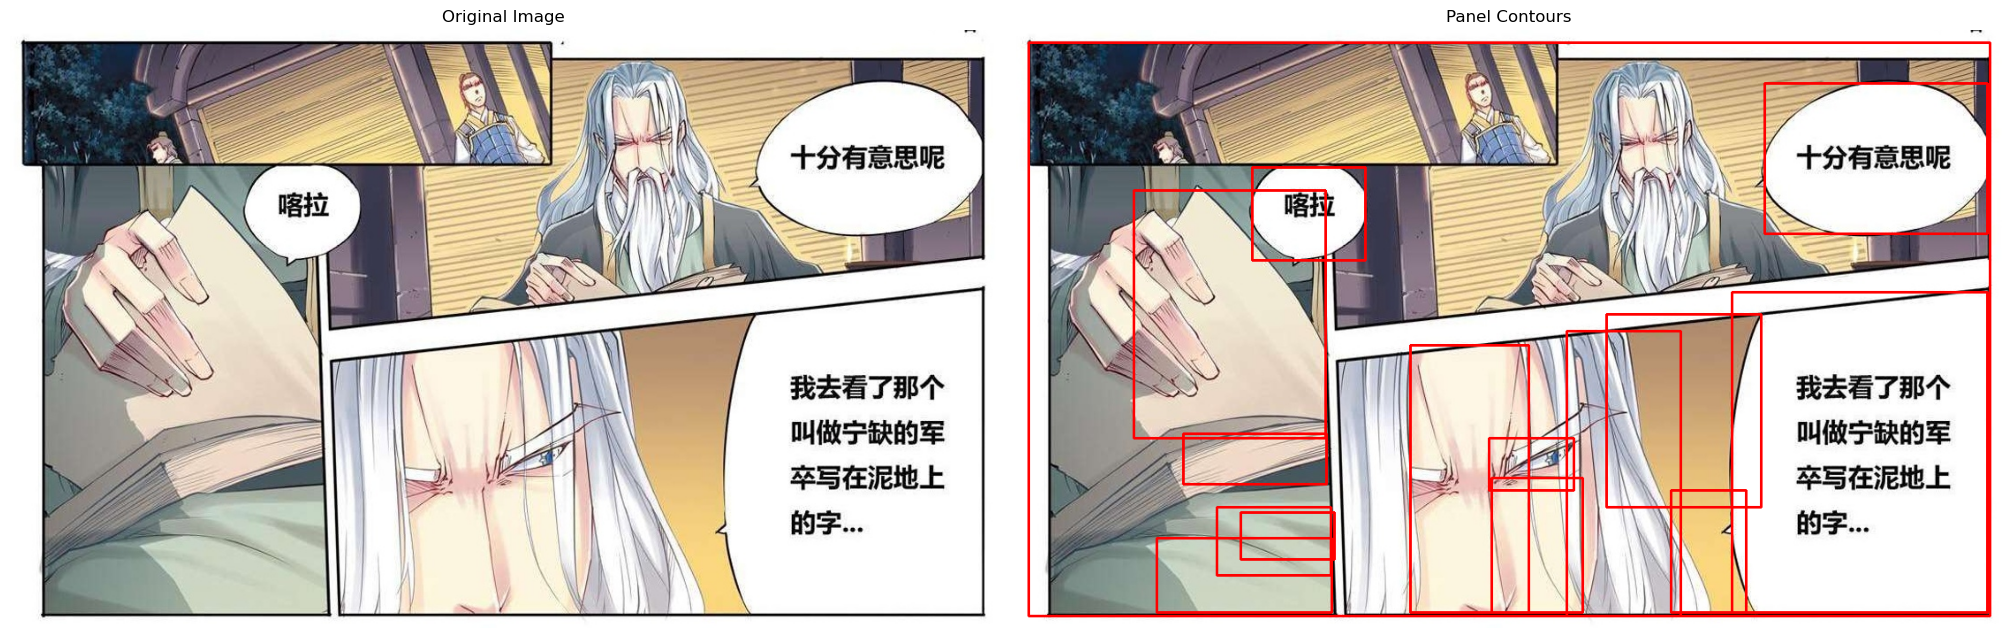

In [4]:
rects = [] # 存储轮廓最小边框坐标
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    rect = np.array([x, y, w, h])
    rects.append(rect)

panel_img = img.copy()
for i in range(len(rects)):
    x, y, w, h = rects[i]
    # 在图像上绘制矩形
    cv2.rectangle(panel_img, (x, y), (x + w, y + h), (0,0,255), 2)

panel = cv2.cvtColor(panel_img, cv2.COLOR_BGR2RGB)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 设置matplotlib中图像的大小
fig, axs = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
 
# 显示原图
axs[0].imshow(img_rgb)
axs[0].set_title('Original Image')
axs[0].axis('off')  # 不显示坐标轴
 
# 显示kernel_3
axs[1].imshow(panel)
axs[1].set_title('Panel Contours')
axs[1].axis('off')  # 不显示坐标轴

plt.show()

In [5]:
def create_roi_image(img, contour):
    """
    提取给定轮廓信息的ROI
    :param img: BGR编码的image图像
    :param contour: 轮廓信息
    :return roi_image: BGR编码的roi图像
    """
    # 创建img的一个全黑掩模
    h, w, c = img.shape # 获取高度,宽度,通道数
    mask = np.zeros((h, w), dtype=np.uint8)
 
    # 在掩模上绘制所有轮廓并填充为白色（ROI）
    cv2.drawContours(mask, [contour], -1, 255, thickness=-1)
 
    # 分割ROI区域
    roi = cv2.bitwise_and(img, img, mask=mask)
    x, y, w, h = cv2.boundingRect(contour)
    roi_image = roi[y:y+h, x:x+w]
    
    return roi_image

In [6]:
def compute_background_ratio(roi_image, lower_bound, upper_bound):
    """
    给定一个灰度值范围，计算范围内的像素点占比
    :param roi_image: 仅包含ROI区域的bgr图像
    :return background_ratio: 像素点占比
    """
    
    # 转换为灰度图像
    gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
    
    total_pixels = gray.size # roi_image的总像素
    
    thresholded_image = cv2.inRange(gray, lower_bound, upper_bound)

    # 统计符合条件的像素数量
    thresholded_pixels = np.sum(thresholded_image == 255)
    
    return round(thresholded_pixels/total_pixels, 2)

In [7]:
bubble_contours = [] # 存储对话框轮廓的坐标
rects = [] # 存储对话框轮廓的最小外接矩形坐标
for i, contour in enumerate(contours):
    roi_image = create_roi_image(img, contour)
    white_ratio = compute_background_ratio(roi_image, 230, 255)
    print(f"index: {i}, white_ratio: {white_ratio}")
    if white_ratio >= 0.3:
        bubble_contours.append(contour)
        x, y, w, h = cv2.boundingRect(contour)
        rect = np.array([x, y, w, h])
        rects.append(rect)

index: 0, white_ratio: 0.0
index: 1, white_ratio: 0.56
index: 2, white_ratio: 0.02
index: 3, white_ratio: 0.57
index: 4, white_ratio: 0.0
index: 5, white_ratio: 0.01
index: 6, white_ratio: 0.82
index: 7, white_ratio: 0.0
index: 8, white_ratio: 0.0
index: 9, white_ratio: 0.0
index: 10, white_ratio: 0.01
index: 11, white_ratio: 0.2
index: 12, white_ratio: 0.67
index: 13, white_ratio: 0.7
index: 14, white_ratio: 0.02


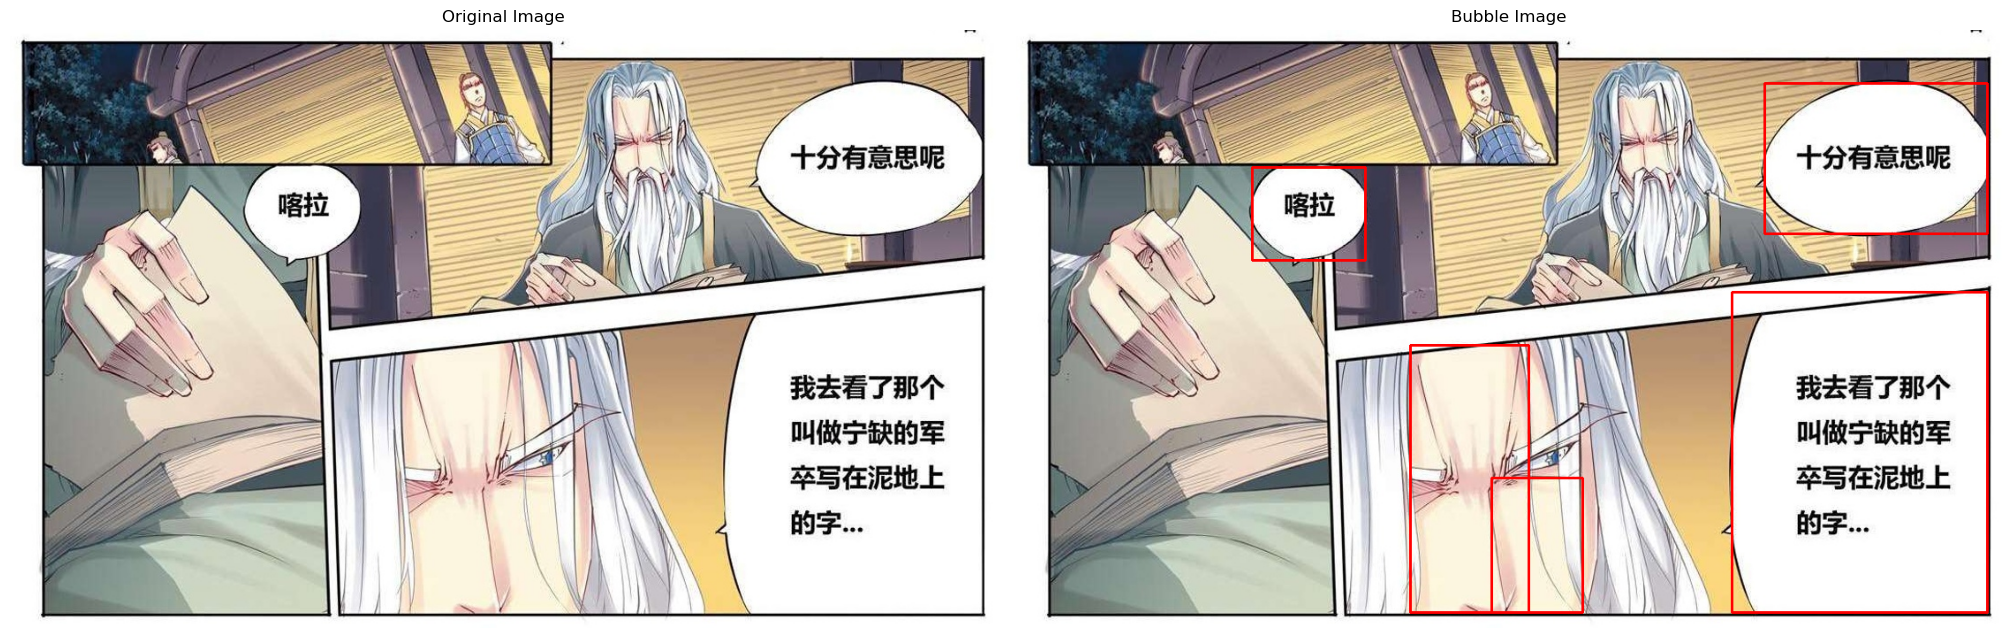

In [8]:
panel_img = img.copy()
for i in range(len(rects)):
    x, y, w, h = rects[i]
    # 在图像上绘制矩形
    cv2.rectangle(panel_img, (x, y), (x + w, y + h), (0,0,255), 2)

panel = cv2.cvtColor(panel_img, cv2.COLOR_BGR2RGB) # 有三级轮廓的二级轮廓

# 设置matplotlib中图像的大小
fig, axs = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
 
# 显示原图
axs[0].imshow(img_rgb)
axs[0].set_title('Original Image')
axs[0].axis('off')  # 不显示坐标轴
 

axs[1].imshow(panel)
axs[1].set_title('Bubble Image')
axs[1].axis('off')  # 不显示坐标轴

plt.show()

# 文字识别